# Previous check of GPU availability
Checking tf version for the compatibility of GPU usage.

In [5]:
import tensorflow as tf

# Check TensorFlow version for compatibility
print("TensorFlow version:", tf.__version__)

# List available GPUs for GPU acceleration
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("GPUs:", physical_devices)
    try:
        # Enable dynamic memory growth (best practice to avoid GPU memory errors)
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except Exception as e:
        pass
else:
    print("No GPU found, using CPU.")

TensorFlow version: 2.10.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load data and importing libraries
Load necesary data from Load_manipulate.ipynb and importing libraries to work

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras_tuner as kt  # Keras Tuner for hyperparameter tuning

# Import necessary libraries for model evaluation
from sklearn.model_selection import cross_val_score, KFold 
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score, make_scorer, precision_score

# Load the OHE molecules
data_combined = pd.read_csv('OHE_data.csv')

# Separate x_data and y_data of the OHE_data
x_data = data_combined.iloc[:, :-1].values  # All columns except the last one
y_data = data_combined['target'].values    # The last column

# Verify the shapes
print(f"x_data shape: {x_data.shape}")
print(f"y_data shape: {y_data.shape}")

# Define the number of atom types and positions
# These should match the one-hot encoding used in the data
n_atom_types = 5          # e.g., 5 atom types (H, F, Cl, Br, I)
n_pos = 16                # number of possible positions (16)
n_features = n_atom_types * n_pos  # total one-hot features

# Load Rmin_abs_mean and Rmin_abs_std
stats = pd.read_csv('Rmin_stats.csv')
Rmin_abs_mean = stats['Rmin_abs_mean'].values[0]
Rmin_abs_std = stats['Rmin_abs_std'].values[0]

# Verify the values extracted from Rmin_stats.csv
print(f"Rmin_abs_mean: {Rmin_abs_mean}")
print(f"Rmin_abs_std: {Rmin_abs_std}")

x_data shape: (1183, 80)
y_data shape: (1183,)
Rmin_abs_mean: -299.8190789518174
Rmin_abs_std: 122.410091966645


# Shuffling and splitting the data for training and test

In [7]:
# Library for data preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#Since we're going to use C-V the shuffle() step is necessary to ensure that the data is randomly ordered before splitting into folds.
x_data, y_data = shuffle(x_data, y_data, random_state=39)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# Save the train and test data to CSV files
x_train_df = pd.DataFrame(x_train, columns=[f'feature_{i}' for i in range(x_train.shape[1])])
y_train_df = pd.DataFrame(y_train, columns=['target'])
x_test_df = pd.DataFrame(x_test, columns=[f'feature_{i}' for i in range(x_test.shape[1])])
y_test_df = pd.DataFrame(y_test, columns=['target'])

x_train_df.to_csv('x_train.csv', index=False)
y_train_df.to_csv('y_train.csv', index=False)
x_test_df.to_csv('x_test.csv', index=False)
y_test_df.to_csv('y_test.csv', index=False)

# Print dataset shape for verification
print(f"Training examples: {len(x_train)}, Test examples: {len(x_test)}")
print(f"Input feature shape: {x_train.shape}, Target shape: {y_train.shape}")

Training examples: 946, Test examples: 237
Input feature shape: (946, 80), Target shape: (946,)


# Architecture of our model
This architecture is designed to respect molecular symmetries and efficiently model both local (1-body) and global (N-body) interactions.

In [8]:
# Define a model-building function for Keras Tuner
def build_model(hp):
    inputs = tf.keras.Input(shape=(n_features,), name='Molecule')
    inputs_aux = tf.keras.layers.Reshape((n_features, 1), name='Molecule_aux')(inputs) # Reshape for 1D cropping
    
    # 1-body part (fixed as defined above, using weight sharing)
    single_position = []
    
    for i in range(n_pos):
        left_crop = i * n_atom_types
        right_crop = n_features - (left_crop + n_atom_types)
        pos_i = tf.keras.layers.Cropping1D(cropping=(left_crop, right_crop))(inputs_aux)
        single_position.append(pos_i)
    
    # Define 1-body submodel (linear layer without bias for each position)
    def make_1body_model():
        inp = tf.keras.Input(shape=(n_atom_types,))
        out = tf.keras.layers.Dense(1, use_bias=False, kernel_initializer='random_normal')(inp) # Linear transformation without bias
        return tf.keras.Model(inp, out)

    # Create one 1-body model per unique position (here 8 unique positions due to symmetry)
    models_1b = [make_1body_model() for _ in range(n_pos // 2)]

    # Apply each 1-body model to the corresponding positions
    outputs_1b = []
    
    for i in range(n_pos // 2):
        outputs_1b.append(models_1b[i](single_position[i]))

    # For the second half of the positions, use the corresponding model from the first half to ensure symmetry
    for i in range(n_pos // 2, n_pos):
        outputs_1b.append(models_1b[n_pos - 1 - i](single_position[i]))
    
    # N-Body term: combine 1-body outputs to capture higher-order interactions
    # Concatenate the 1-body outputs for the molecule in normal and reversed order (to enforce invariance under reversal)
    x = tf.keras.layers.Concatenate()(outputs_1b)
    x_rev = tf.keras.layers.Concatenate()(list(reversed(outputs_1b)))
    
    # N-body part hyperparameters
    units = hp.Choice('units', [128, 256, 512])
    layers = hp.Choice('layers', [1, 2, 3, 4])
    dropout = hp.Choice('dropout_rate', [0.0, 0.3, 0.5])
    
    # Define the N-body interaction model (will be applied to both x and x_rev)
    def build_nbody_model(units=512, layers=1, dropout_rate=0.5):
        """Builds a small feed-forward network for N-body interactions."""
        inputs_nb = tf.keras.Input(shape=(n_pos,))
        nn = tf.keras.layers.Dense(units, activation='relu', 
                                kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                                kernel_initializer='random_normal', bias_initializer='zeros')(inputs_nb)
        nn = tf.keras.layers.Dropout(dropout_rate)(nn)
        if layers == 2:
            # If a second hidden layer is desired
            nn = tf.keras.layers.Dense(units, activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                                    kernel_initializer='random_normal', bias_initializer='zeros')(nn)
            nn = tf.keras.layers.Dropout(dropout_rate)(nn)
        output_nb = tf.keras.layers.Dense(1)(nn)
        return tf.keras.Model(inputs_nb, output_nb, name='N-body')
    
    # Build N-body submodel with the hyperparameters
    nbody_net = build_nbody_model(units=units, layers=layers, dropout_rate=dropout)
    out1 = nbody_net(x)
    out2 = nbody_net(x_rev)
    total_out = tf.keras.layers.Add()([out1, out2])
    model = tf.keras.Model(inputs, total_out)
    
    # Compile model with a tunable learning rate
    lr = hp.Choice('learning_rate', [1e-2, 5e-3, 1e-3])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mean_absolute_error')
    return model

# Hyperparameter tunning
Search for the most suitable hyperparameters to avoid problems like over/under-fitting or unstable trainings, using the complexity of our model relationships as a bias.

In [9]:
# Set up Hyperband tuner to search hyperparameters
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',        # Objective to optimize
    max_epochs=100,              # maximum epochs to train for each model
    factor=3,                    # Hyperband reduction factor
    directory='kt_dir',          # Directory to save the results
    project_name='Rmin_Invariant_Nbody_Tuning' # Project name for Keras Tuner
)

# Use early stopping during hyperparameter search to curtail long trainings
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Run the hyperparameter search
tuner.search(x_train, y_train, validation_split=0.1, epochs=300, batch_size=8, callbacks=[stop_early], verbose=2)

# Get the optimal hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: units={best_hp.get('units')}, layers={best_hp.get('layers')}, "
      f"dropout_rate={best_hp.get('dropout_rate')}, learning_rate={best_hp.get('learning_rate')}")

# Save best_hp to a JSON file
import json

best_hp_dict = best_hp.values  # Extract the hyperparameters as a dictionary
with open("best_hp.json", "w") as f:
    json.dump(best_hp_dict, f)


Reloading Tuner from kt_dir\Rmin_Invariant_Nbody_Tuning\tuner0.json
Best hyperparameters: units=512, layers=4, dropout_rate=0.0, learning_rate=0.005


# Prediction vs. True values plot
Plot for the visualization of the convergence of true and predicted data.

In [10]:
def plot_PredvsTrue(y_true_test, y_pred_test, y_true_train, y_pred_train, i_CV=0):
    plt.figure(figsize=(3, 3), dpi=200)
    plt.title(f"Regression of R, CV {i_CV}", fontsize=10)

    # Improved Axis Scaling
    p1 = min(y_true_test)
    p2 = max(y_true_test)
    plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")

    # Scatter Plots
    sns.scatterplot(x=y_true_train, y=y_pred_train, color="orange", s=8, label="Train")
    sns.scatterplot(x=y_true_test, y=y_pred_test, color="blue", s=8, label="Test")

    plt.xlabel("True", fontsize=12)
    plt.ylabel("Pred", fontsize=12)
    plt.legend(loc="upper left", fontsize=10)
    plt.grid(False)

    """# Save Figure
    plt.savefig(f"regression_cv_{i_CV}.png", dpi=300, bbox_inches="tight")
    plt.show()"""

# Mean Absolute Value vs. n_subs
Computes and visualizes the error as a function of the number of substitutes.

In [11]:
#function to compute error for different nsubs on test set
def error_vs_nsubs(x_test, y_pred_test, y_true_test):
    # Vectorized computation of number of substitutes per sample
    nsubs_test = np.sum(x_test[:, ::n_atom_types] == 0, axis=1)

    # Create DataFrame for easy grouping
    df = pd.DataFrame({"nsubs": nsubs_test, "error": np.abs(y_pred_test - y_true_test)})
    
    # Compute MAE per substitute group
    error_nsubs = df.groupby("nsubs")["error"].mean().reindex(range(7), fill_value=0).values
    num_subs = df["nsubs"].value_counts().reindex(range(7), fill_value=0).values

    # Remove the 0 index (no substitutes)
    error_nsubs = error_nsubs[1:]
    num_subs = num_subs[1:]

    # Print number of samples per group
    print("Number of samples per n_subs (1-6):", num_subs)
    print("Mean Absolute Error per n_subs (1-6):", error_nsubs)

    # Plot MAE vs nsubs (starting from 1)
    plt.figure(figsize=(5, 4))
    sns.barplot(x=np.arange(1, 7), y=error_nsubs)
    plt.xlabel("Number of Substitutes (n_subs)", fontsize=14)
    plt.ylabel("Mean Absolute Error (MAE)", fontsize=14)
    plt.ylim([0, 100])
    plt.grid(False)
    plt.show()

    return error_nsubs

# Cross Validation
Implementation of fold-cross-validation to evaluate the model's performance.

34/34 [==============================] - 0s 1ms/step
Fold 1/10
  Train MAE: 55.2829, Train RMSE: 71.5570, Train MAPE: 20.87%, Train R²: 0.6620
  Test  MAE: 63.2017, Test  RMSE: 81.5018, Test  MAPE: 24.95%, Test  R²: 0.4974
--------------------------------------------------------------------------------
Number of samples per n_subs (1-6): [ 3 14 16 24 28 34]
Mean Absolute Error per n_subs (1-6): [80.34695303 58.44877594 49.60651093 62.01701794 60.08383337 73.44749696]


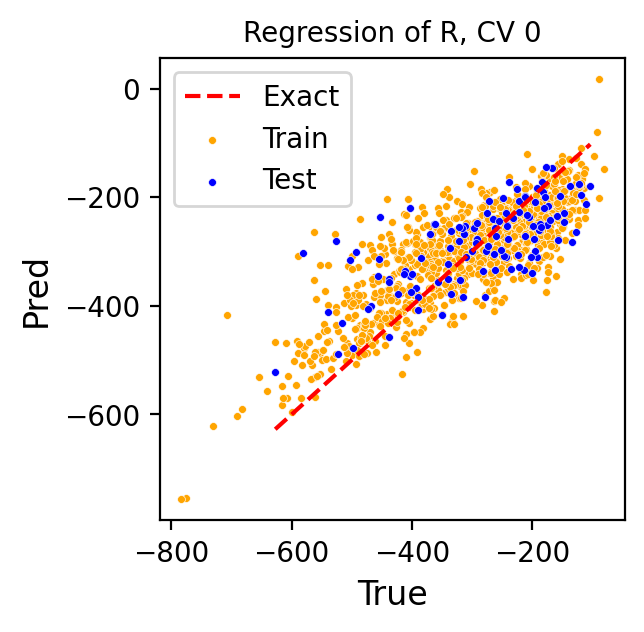

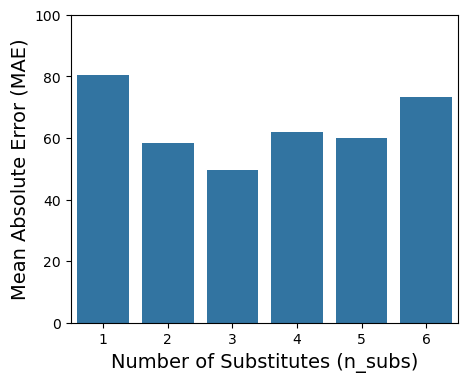

34/34 [==============================] - 0s 1ms/step
Fold 2/10
  Train MAE: 63.0465, Train RMSE: 82.9193, Train MAPE: 21.68%, Train R²: 0.5333
  Test  MAE: 74.0634, Test  RMSE: 95.4550, Test  MAPE: 25.14%, Test  R²: 0.4573
--------------------------------------------------------------------------------
Number of samples per n_subs (1-6): [ 0 17 28 28 11 35]
Mean Absolute Error per n_subs (1-6): [ 0.         72.00026078 79.97218902 77.32718101 63.7031065  70.9835975 ]


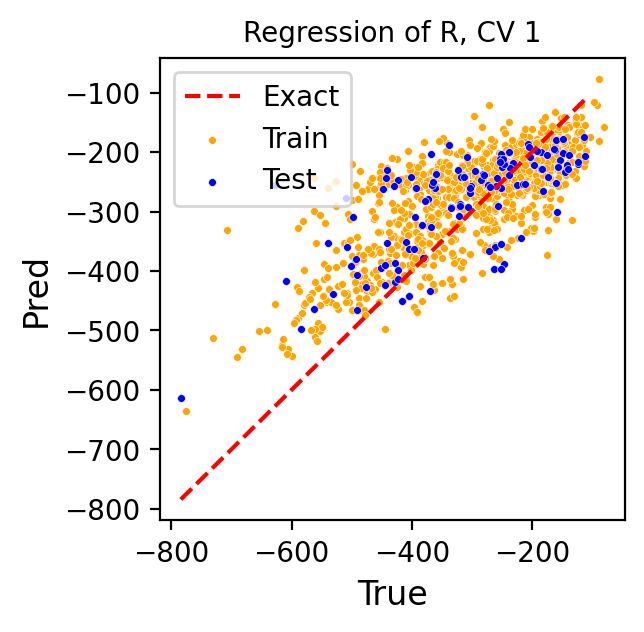

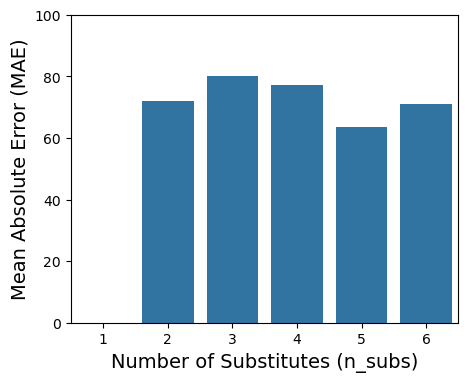

34/34 [==============================] - 0s 1ms/step
Fold 3/10
  Train MAE: 52.3674, Train RMSE: 70.1957, Train MAPE: 19.71%, Train R²: 0.6646
  Test  MAE: 62.2264, Test  RMSE: 80.4667, Test  MAPE: 22.60%, Test  R²: 0.6280
--------------------------------------------------------------------------------
Number of samples per n_subs (1-6): [ 5 11 23 21 20 39]
Mean Absolute Error per n_subs (1-6): [25.15373641 55.33396185 56.49879567 60.33867489 70.04521084 69.3080989 ]


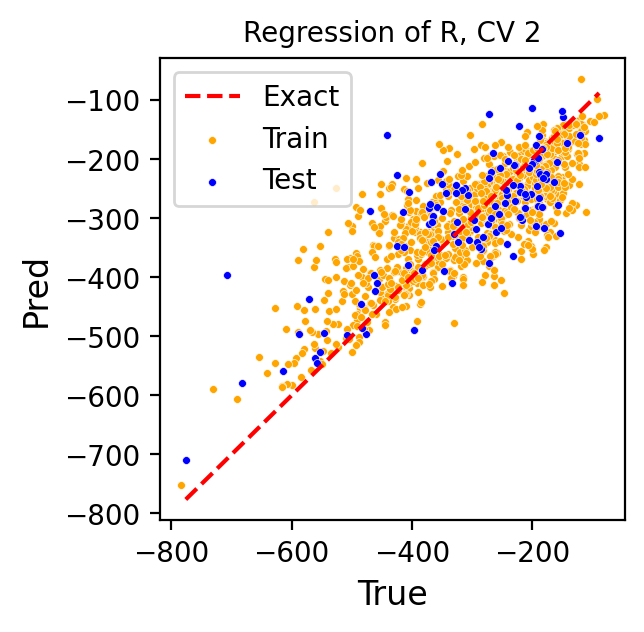

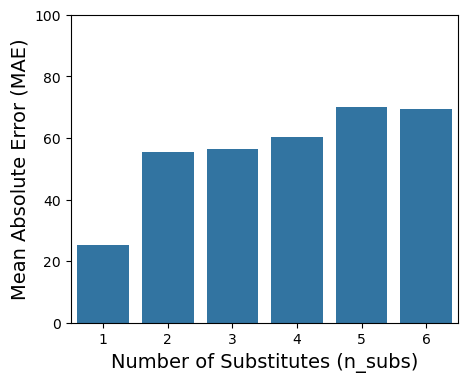

34/34 [==============================] - 0s 1ms/step
Fold 4/10
  Train MAE: 52.6418, Train RMSE: 71.2137, Train MAPE: 19.35%, Train R²: 0.6683
  Test  MAE: 67.5276, Test  RMSE: 83.2920, Test  MAPE: 25.94%, Test  R²: 0.4228
--------------------------------------------------------------------------------
Number of samples per n_subs (1-6): [ 1 16 17 24 21 39]
Mean Absolute Error per n_subs (1-6): [95.74996362 48.92998281 59.40959253 77.59106142 85.0883742  62.3237644 ]


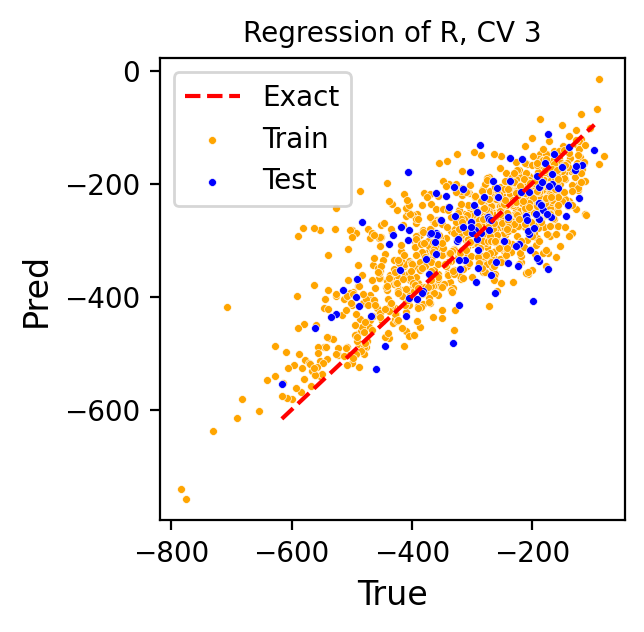

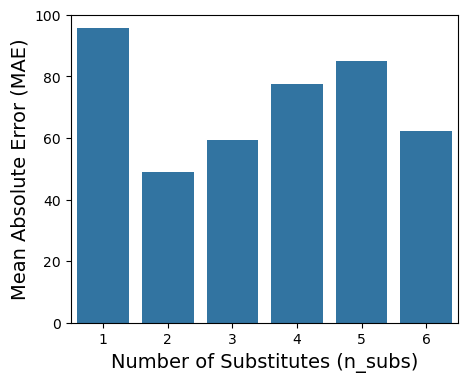

34/34 [==============================] - 0s 1ms/step
Fold 5/10
  Train MAE: 58.5183, Train RMSE: 77.2284, Train MAPE: 21.12%, Train R²: 0.5966
  Test  MAE: 57.8447, Test  RMSE: 76.2462, Test  MAPE: 22.27%, Test  R²: 0.6504
--------------------------------------------------------------------------------
Number of samples per n_subs (1-6): [ 4 22 22 12 22 36]
Mean Absolute Error per n_subs (1-6): [17.21197743 60.30097226 71.50707474 84.80402561 62.21064467 40.85469953]


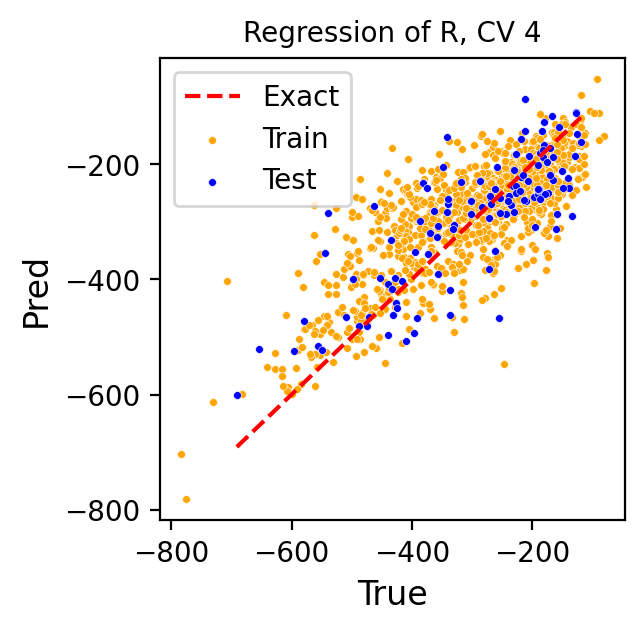

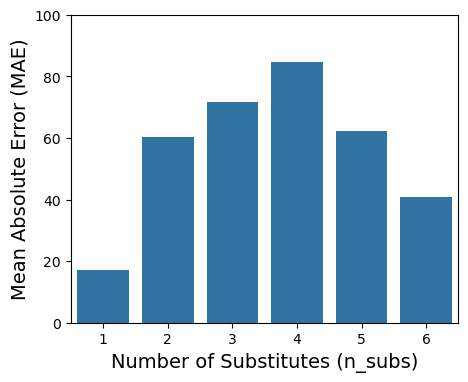

34/34 [==============================] - 0s 1ms/step
Fold 6/10
  Train MAE: 60.4711, Train RMSE: 81.0407, Train MAPE: 20.45%, Train R²: 0.5654
  Test  MAE: 68.0858, Test  RMSE: 88.7125, Test  MAPE: 23.45%, Test  R²: 0.4248
--------------------------------------------------------------------------------
Number of samples per n_subs (1-6): [ 3  7 24 12 24 48]
Mean Absolute Error per n_subs (1-6): [21.37322635 67.75309105 65.68427959 45.78125463 56.09503891 83.82608954]


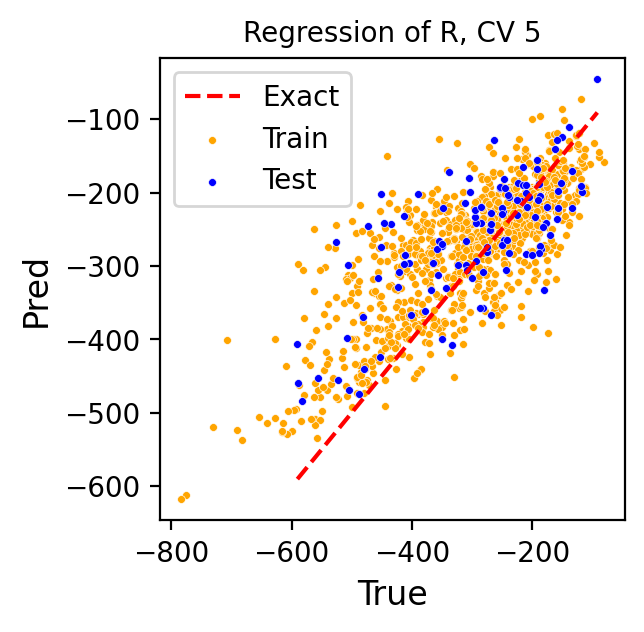

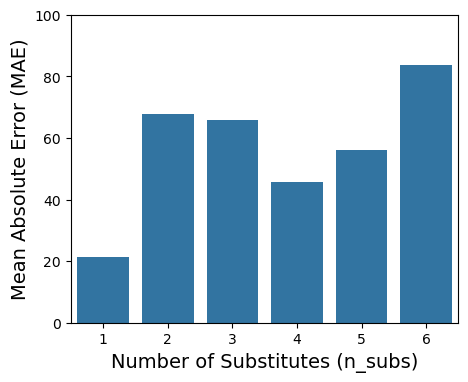

34/34 [==============================] - 0s 1ms/step
Fold 7/10
  Train MAE: 58.0284, Train RMSE: 77.2798, Train MAPE: 20.66%, Train R²: 0.6027
  Test  MAE: 72.4649, Test  RMSE: 89.4841, Test  MAPE: 25.75%, Test  R²: 0.4434
--------------------------------------------------------------------------------
Number of samples per n_subs (1-6): [ 2 16 20 22 22 36]
Mean Absolute Error per n_subs (1-6): [38.27771973 76.95876099 72.33966564 76.35441858 69.74566395 71.72132077]


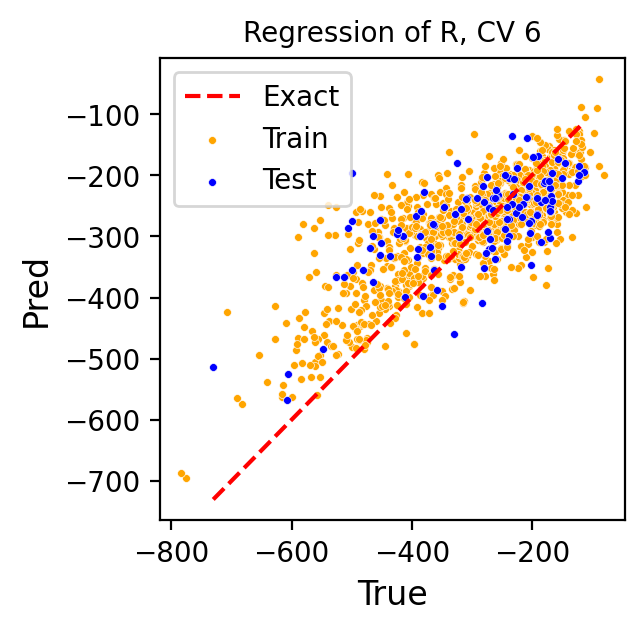

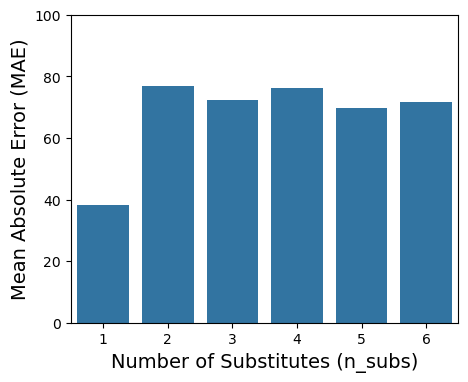

34/34 [==============================] - 0s 1ms/step
Fold 8/10
  Train MAE: 66.2380, Train RMSE: 87.8686, Train MAPE: 22.09%, Train R²: 0.4840
  Test  MAE: 70.0672, Test  RMSE: 94.3455, Test  MAPE: 22.47%, Test  R²: 0.4083
--------------------------------------------------------------------------------
Number of samples per n_subs (1-6): [ 3 13 19 25 23 35]
Mean Absolute Error per n_subs (1-6): [41.90436877 69.79452653 52.96703965 76.21438885 65.59327909 80.41438596]


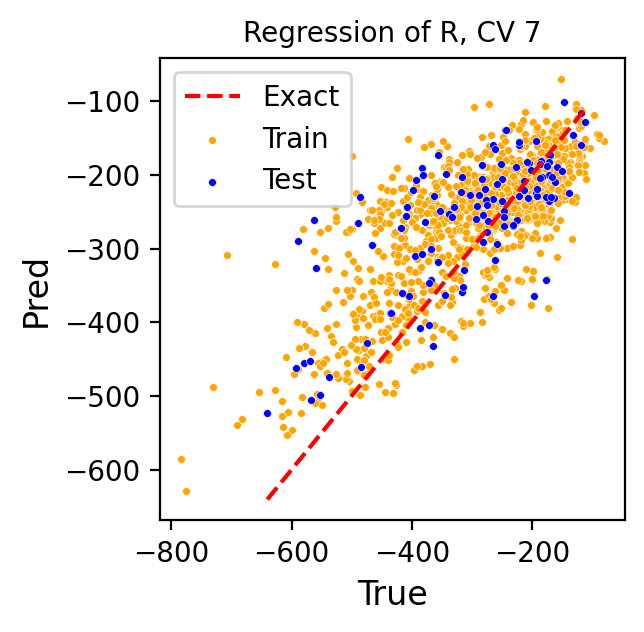

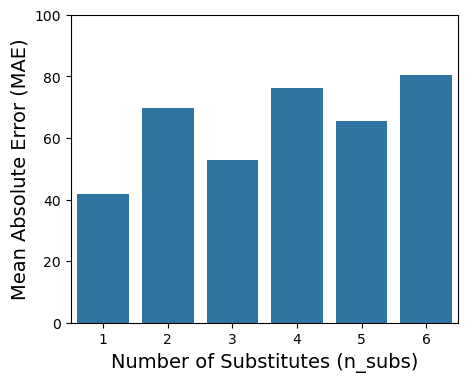

34/34 [==============================] - 0s 1ms/step
Fold 9/10
  Train MAE: 49.7890, Train RMSE: 69.0423, Train MAPE: 18.20%, Train R²: 0.6816
  Test  MAE: 71.6091, Test  RMSE: 93.1234, Test  MAPE: 24.36%, Test  R²: 0.4188
--------------------------------------------------------------------------------
Number of samples per n_subs (1-6): [ 5 16 16 21 19 41]
Mean Absolute Error per n_subs (1-6): [66.95667517 95.02319878 68.87501015 92.50566873 58.83531172 59.3225529 ]


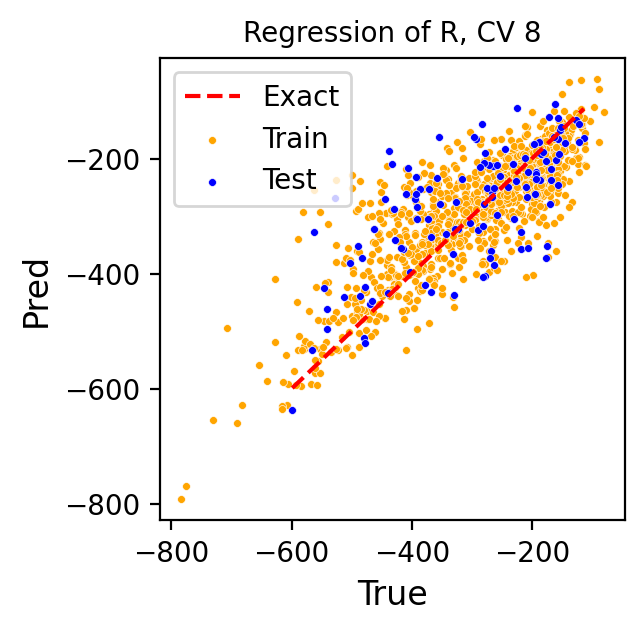

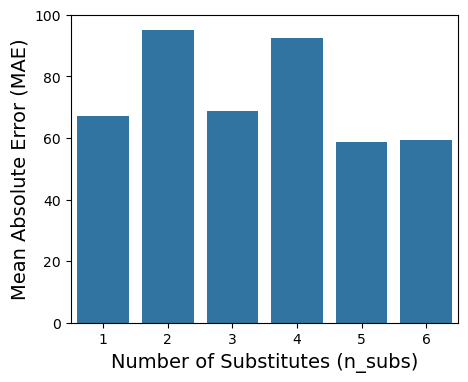

34/34 [==============================] - 0s 1ms/step
Fold 10/10
  Train MAE: 52.6010, Train RMSE: 71.7054, Train MAPE: 18.95%, Train R²: 0.6568
  Test  MAE: 61.7544, Test  RMSE: 79.6510, Test  MAPE: 22.08%, Test  R²: 0.5739
--------------------------------------------------------------------------------
Number of samples per n_subs (1-6): [ 6 18 18 20 20 35]
Mean Absolute Error per n_subs (1-6): [34.73688417 56.90491588 67.80995112 76.72913751 70.39417408 53.85415551]


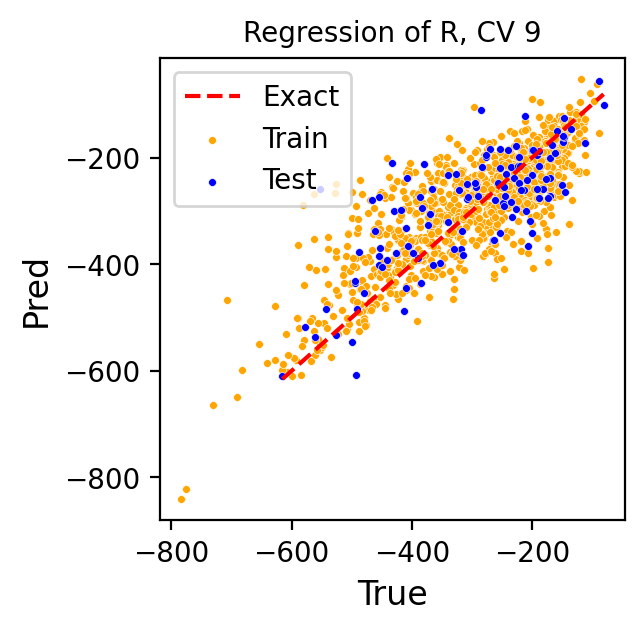

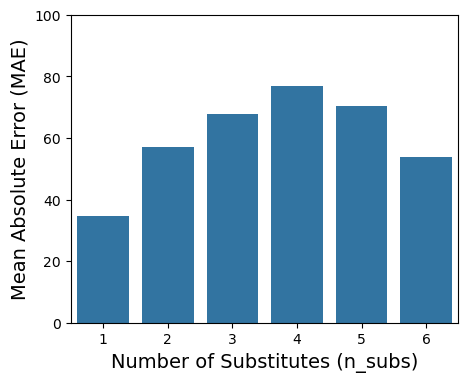

In [12]:
# Number of folds for cross-validation
n_crossvalidation = 10

# Initialize error accumulator for nsubs
error_nsubs_accu = np.zeros(6)  # Assuming there are 7 unique nsubs values

# Initialize metric arrays
test_mae_CV = np.zeros(n_crossvalidation)
test_rmse_CV = np.zeros(n_crossvalidation)
test_mape_CV = np.zeros(n_crossvalidation)
test_r2_CV = np.zeros(n_crossvalidation)
train_mae_CV = np.zeros(n_crossvalidation)
train_rmse_CV = np.zeros(n_crossvalidation)
train_mape_CV = np.zeros(n_crossvalidation)
train_r2_CV = np.zeros(n_crossvalidation)

# Build the model once and save initial weights
best_model = build_model(best_hp)
initial_weights = best_model.get_weights()

from sklearn.model_selection import KFold

kf = KFold(n_splits=n_crossvalidation, shuffle=True, random_state=42)
for i_crossval, (train_idx, test_idx) in enumerate(kf.split(x_data)):
    x_train, x_test = x_data[train_idx], x_data[test_idx]
    y_train, y_test = y_data[train_idx], y_data[test_idx]

    # Reset model weights
    best_model.set_weights(initial_weights)
    
    # Setup callbacks: Reduce LR on plateau and EarlyStopping for final training
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.15, patience=30, min_lr=1e-8)
    early_stop_final = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    # Train the model
    history = best_model.fit(
        x_train, y_train,
        epochs=600,
        batch_size=4,
        validation_split=0.1,
        callbacks=[reduce_lr, early_stop_final],
        verbose=0
    )
    
    def invert_normalization(y_pred, y_true, mean, std):
        y_pred = y_pred * std + mean
        y_true = y_true * std + mean
        return y_pred.ravel(), y_true.ravel()

    # Evaluate metrics
    y_pred_test, y_true_test = invert_normalization(best_model.predict(x_test), y_test, Rmin_abs_mean, Rmin_abs_std)
    y_pred_train, y_true_train = invert_normalization(best_model.predict(x_train), y_train, Rmin_abs_mean, Rmin_abs_std)
    
    plot_PredvsTrue(y_true_test, y_pred_test, y_true_train, y_pred_train, i_CV=i_crossval)
    
    def calculate_metrics(y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = mean_absolute_percentage_error(y_true, y_pred) * 100
        r2 = r2_score(y_true, y_pred)
        return mae, rmse, mape, r2
    
    test_mae, test_rmse, test_mape, test_r2 = calculate_metrics(y_true_test, y_pred_test)
    train_mae, train_rmse, train_mape, train_r2 = calculate_metrics(y_true_train, y_pred_train)
    
    # Save metrics
    test_mae_CV[i_crossval] = test_mae
    test_rmse_CV[i_crossval] = test_rmse
    test_mape_CV[i_crossval] = test_mape
    test_r2_CV[i_crossval] = test_r2
    train_mae_CV[i_crossval] = train_mae
    train_rmse_CV[i_crossval] = train_rmse
    train_mape_CV[i_crossval] = train_mape
    train_r2_CV[i_crossval] = train_r2

    # Print metrics for the current fold
    print(f"Fold {i_crossval + 1}/{n_crossvalidation}")
    print(f"  Train MAE: {train_mae:.4f}, Train RMSE: {train_rmse:.4f}, Train MAPE: {train_mape:.2f}%, Train R²: {train_r2:.4f}")
    print(f"  Test  MAE: {test_mae:.4f}, Test  RMSE: {test_rmse:.4f}, Test  MAPE: {test_mape:.2f}%, Test  R²: {test_r2:.4f}")
    print("-" * 80)

    # Compute error for different nsubs on the test set
    error_nsubs = error_vs_nsubs(x_test, y_pred_test, y_true_test)
    error_nsubs_accu = error_nsubs_accu + error_nsubs

# Compute mean error for each nsubs value across folds
error_nsubs_mean = error_nsubs_accu / n_crossvalidation

# Resulting metrics from CV

In [13]:
# Define metric names
metrics = ["mae", "rmse", "mape", "r2"]

# Compute mean and standard deviation for each metric
results = {
    f"train_{metric}": (np.mean(eval(f"train_{metric}_CV")), np.std(eval(f"train_{metric}_CV")))
    for metric in metrics
}
results.update({
    f"test_{metric}": (np.mean(eval(f"test_{metric}_CV")), np.std(eval(f"test_{metric}_CV")))
    for metric in metrics
})

# Print results in formatted output
for metric in metrics:
    print(f"Train {metric.upper()}: {results[f'train_{metric}'][0]:.6f} ± {results[f'train_{metric}'][1]:.6f}")
    print(f"Test {metric.upper()}: {results[f'test_{metric}'][0]:.6f} ± {results[f'test_{metric}'][1]:.6f}")
    print()

Train MAE: 56.898421 ± 5.019571
Test MAE: 66.884515 ± 5.101783

Train RMSE: 76.005094 ± 6.004069
Test RMSE: 86.227804 ± 6.499204

Train MAPE: 20.308248 ± 1.174269
Test MAPE: 23.900828 ± 1.424793

Train R2: 0.611532 ± 0.063524
Test R2: 0.492509 ± 0.086920



# Mean MAE for substituent
With all the MAE values obtained for each substituent in each fold, will do the mean value.

n_subs = 0: MAE = 42.17
n_subs = 1: MAE = 66.14
n_subs = 2: MAE = 64.47
n_subs = 3: MAE = 72.97
n_subs = 4: MAE = 66.18
n_subs = 5: MAE = 66.61


'# Save Plot\nplt.savefig("mean_error_vs_nsubs.png", dpi=300, bbox_inches="tight")\nplt.show()'

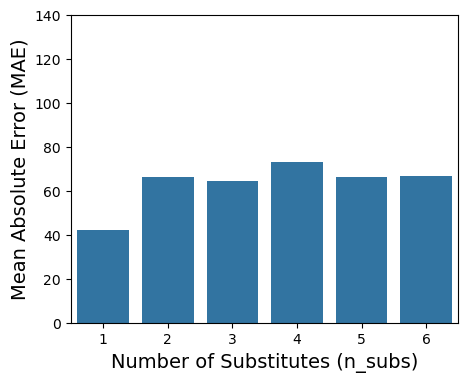

In [14]:
# Print formatted MAE values
for i, err in enumerate(error_nsubs_mean):
    print(f"n_subs = {i}: MAE = {err:.2f}")

# Enhanced Visualization
plt.figure(figsize=(5, 4))
sns.barplot(x=np.arange(1, 7), y=error_nsubs_mean)

plt.xlabel("Number of Substitutes (n_subs)", fontsize=14)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=14)
plt.grid(False)
plt.ylim([0, 140])

"""# Save Plot
plt.savefig("mean_error_vs_nsubs.png", dpi=300, bbox_inches="tight")
plt.show()"""


# Traning of the final model
Train with all the available data to check model performance.

In [15]:
import os

# Ensure the directory exists
os.makedirs('./CV_Models/', exist_ok=True)

# Reinitialize the model
best_model = build_model(best_hp)

# Use a fixed learning rate for stability
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
best_model.compile(optimizer=optimizer, loss='mean_absolute_error')

# Train the model with smaller batch size and fixed validation set
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=42)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

history = best_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=1000,
    batch_size=64,
    verbose=2,
    callbacks=[early_stop]
)

# Save loss history
with open("loss_history.json", "w") as f:
    json.dump(history.history, f)

# Save the model in the SavedModel format
best_model.save('./CV_Models/Rmin_model_CV')

# Predict and invert normalization
y_pred_data = best_model.predict(x_data).ravel() * Rmin_abs_std + Rmin_abs_mean
y_true_data = y_data.ravel() * Rmin_abs_std + Rmin_abs_mean

# Compute final metrics
final_metrics = {
    "mae": mean_absolute_error(y_true_data, y_pred_data),
    "rmse": np.sqrt(mean_squared_error(y_true_data, y_pred_data)),
    "mape": mean_absolute_percentage_error(y_true_data, y_pred_data) * 100,
    "r2": r2_score(y_true_data, y_pred_data)
}

# Save final metrics
with open("final_metrics.json", "w") as f:
    json.dump(final_metrics, f, indent=4)

# Print final metrics
print("\nFinal Model Metrics:")
for metric, value in final_metrics.items():
    print(f"{metric.upper()}: {value:.6f}")

Epoch 1/1000
17/17 - 1s - loss: 0.8166 - val_loss: 0.7516 - 643ms/epoch - 38ms/step
Epoch 2/1000
17/17 - 0s - loss: 0.7916 - val_loss: 0.7299 - 76ms/epoch - 4ms/step
Epoch 3/1000
17/17 - 0s - loss: 0.7653 - val_loss: 0.7014 - 72ms/epoch - 4ms/step
Epoch 4/1000
17/17 - 0s - loss: 0.7210 - val_loss: 0.6603 - 77ms/epoch - 5ms/step
Epoch 5/1000
17/17 - 0s - loss: 0.6770 - val_loss: 0.6809 - 70ms/epoch - 4ms/step
Epoch 6/1000
17/17 - 0s - loss: 0.6348 - val_loss: 0.6364 - 74ms/epoch - 4ms/step
Epoch 7/1000
17/17 - 0s - loss: 0.6072 - val_loss: 0.6379 - 72ms/epoch - 4ms/step
Epoch 8/1000
17/17 - 0s - loss: 0.5953 - val_loss: 0.6446 - 71ms/epoch - 4ms/step
Epoch 9/1000
17/17 - 0s - loss: 0.5829 - val_loss: 0.5935 - 76ms/epoch - 4ms/step
Epoch 10/1000
17/17 - 0s - loss: 0.5734 - val_loss: 0.5954 - 72ms/epoch - 4ms/step
Epoch 11/1000
17/17 - 0s - loss: 0.5622 - val_loss: 0.6006 - 71ms/epoch - 4ms/step
Epoch 12/1000
17/17 - 0s - loss: 0.5523 - val_loss: 0.5827 - 73ms/epoch - 4ms/step
Epoch 13/10

INFO:tensorflow:Assets written to: ./CV_Models/Rmin_model_CV\assets


INFO:tensorflow:Assets written to: ./CV_Models/Rmin_model_CV\assets


37/37 [==============================] - 0s 1ms/step

Final Model Metrics:
MAE: 57.570398
RMSE: 76.818188
MAPE: 20.723525
R2: 0.605851
